Using device: cuda
dat shape (neurons × trials): (39209, 5900)

⏬ Checking/Downloading: zer0int/CLIP-SAE-ViT-L-14


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

✓ Files present.

🔍 Scanning safetensors for encoder-like matrices...
  model.safetensors: text_model.embeddings.token_embedding.weight shape=(49408, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.1.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.1.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.10.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.10.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.11.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.11.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: text_model.encoder.layers.2.mlp.fc1.weight shape=(3072, 768)
  model.safetensors: text_model.encoder.layers.2.mlp.fc2.weight shape=(768, 3072)
  model.safetensors: 

Feature extraction: 100%|██████████| 118/118 [00:08<00:00, 13.32it/s]


Baseline CLIP shape: (118, 1024) | SAE latent shape: (118, 49408)

Running 5-fold CV (KNN latent mapping, K=3) on 10 neurons...


Neurons: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]



✅ Saved → clip_sae_vitl14_knn_results.csv


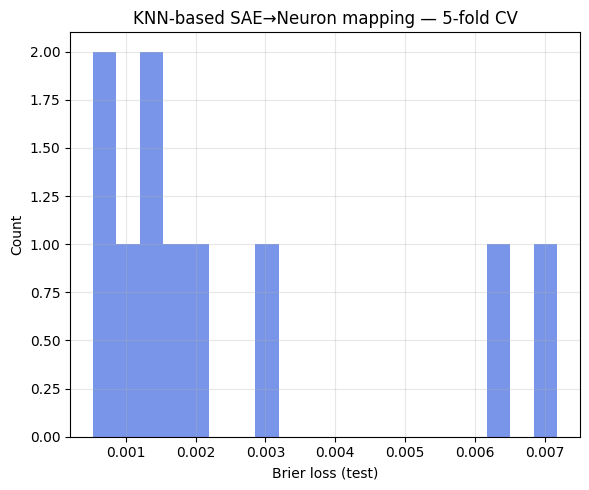

In [4]:
#!/usr/bin/env python3
# =====================================================================
# Allen Mouse Neurons — CLIP-SAE-ViT-L-14  → Neuron Mapping via KNN
# =====================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from safetensors import safe_open
from huggingface_hub import snapshot_download
from transformers import CLIPProcessor, CLIPModel
from transformers.models.clip.modeling_clip import CLIPVisionModel
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

# -----------------------------
# Config / constants
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)
print(f"Using device: {DEVICE}")

N_IMAGES = 118
N_TRIALS = 50
DATA_PATH = "/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
IMG_DIR = Path("/home/maria/MITNeuralComputation/vit_embeddings/images")
SAE_REPO = "zer0int/CLIP-SAE-ViT-L-14"
LOCAL_SAE_DIR = "./clip_sae_vitl14_weights"

# -----------------------------
# Helper: Brier loss
# -----------------------------
def compute_brier(y_true, y_pred, img_ids):
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    return float(np.mean((agg["p"] - agg["y"]) ** 2))

# -----------------------------
# Load neural data
# -----------------------------
dat = np.load(DATA_PATH)
print("dat shape (neurons × trials):", dat.shape)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
assert n_samples == N_IMAGES * N_TRIALS
img_ids_full = np.repeat(np.arange(N_IMAGES), N_TRIALS)

# -----------------------------
# Download SAE repo if needed
# -----------------------------
print("\n⏬ Checking/Downloading:", SAE_REPO)
snapshot_download(repo_id=SAE_REPO, local_dir=LOCAL_SAE_DIR)
print("✓ Files present.")

# -----------------------------
# Load CLIP backbone + processor
# -----------------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
vision_model: CLIPVisionModel = clip_model.vision_model

# -----------------------------
# Find SAE encoder matrix
# -----------------------------
print("\n🔍 Scanning safetensors for encoder-like matrices...")
candidates = []
for f in Path(LOCAL_SAE_DIR).glob("*.safetensors"):
    with safe_open(f, framework="pt", device="cpu") as sf:
        for k in sf.keys():
            t = sf.get_tensor(k)
            if t.ndim == 2:
                candidates.append((f, k, t.shape))
                if t.shape[0] * t.shape[1] > 1_000_000:
                    print(f"  {f.name}: {k} shape={tuple(t.shape)}")

if not candidates:
    raise FileNotFoundError("No 2D tensors found in any .safetensors file.")
sae_path, enc_key, enc_shape = max(candidates, key=lambda x: x[2][0] * x[2][1])
print(f"→ Selected {enc_key} from {sae_path.name} with shape {enc_shape}")

with safe_open(sae_path, framework="pt", device=DEVICE) as f:
    W = f.get_tensor(enc_key)
    bias = None
    for k in f.keys():
        if "bias" in k.lower():
            b = f.get_tensor(k)
            if b.ndim == 1 and (b.shape[0] == W.shape[0] or b.shape[0] == W.shape[1]):
                bias = b
                bias_key = k
                break
if bias is None:
    bias = None
print(f"Loaded encoder weight W: {tuple(W.shape)}, bias found: {bias is not None}")

# -----------------------------
# CLIP feature extractors
# -----------------------------
def feat_pooled_1024(inputs):
    outs = vision_model(**inputs)
    return outs.last_hidden_state.mean(dim=1)

def feat_image_proj_768(inputs):
    return clip_model.get_image_features(**inputs)

def feat_flat_resid_with_cls(inputs):
    outs = vision_model(**inputs)
    x = outs.last_hidden_state
    return x.flatten(start_dim=1)

def feat_flat_resid_no_cls(inputs):
    outs = vision_model(**inputs)
    x = outs.last_hidden_state[:, 1:, :]
    return x.flatten(start_dim=1)

extractors = [
    ("pooled_1024",        feat_pooled_1024,        1024),
    ("image_proj_768",     feat_image_proj_768,      768),
    ("flat_resid_withCLS", feat_flat_resid_with_cls, 257 * 1024),
    ("flat_resid_noCLS",   feat_flat_resid_no_cls,   256 * 1024),
]

def pick_mapping(W, bias):
    A, B = W.shape
    for name, fn, dim in extractors:
        if dim == B:
            out_dim, in_dim, use_T, extractor = A, B, False, (name, fn)
            b_vec = bias if (bias is not None and bias.shape[0] == A) else torch.zeros(A, device=DEVICE)
            return out_dim, in_dim, use_T, extractor, b_vec
        if dim == A:
            out_dim, in_dim, use_T, extractor = B, A, True, (name, fn)
            b_vec = bias if (bias is not None and bias.shape[0] == B) else torch.zeros(B, device=DEVICE)
            return out_dim, in_dim, use_T, extractor, b_vec
    return None

mapping = pick_mapping(W, bias)
if mapping is None:
    raise RuntimeError("Could not match encoder to CLIP features.")

OUT_DIM, IN_DIM, USE_T, (EXTRACTOR_NAME, EXTRACTOR_FN), B_VEC = mapping
print(f"✓ Matched encoder to extractor='{EXTRACTOR_NAME}' "
      f"(in_dim={IN_DIM}, out_dim={OUT_DIM}, transpose={USE_T})")

W_use = W.T if USE_T else W
if B_VEC.shape[0] != OUT_DIM:
    B_VEC = torch.zeros(OUT_DIM, device=DEVICE)
print(f"Final encoder weight: {tuple(W_use.shape)}, bias: {tuple(B_VEC.shape)}")

# -----------------------------
# SAE encoder module
# -----------------------------
class SAEEncoder(torch.nn.Module):
    def __init__(self, in_dim, out_dim, W_init, b_init):
        super().__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim, bias=True)
        with torch.no_grad():
            self.linear.weight.copy_(W_init)
            self.linear.bias.copy_(b_init)
    def forward(self, x):
        return torch.relu(self.linear(x))

sae = SAEEncoder(IN_DIM, OUT_DIM, W_use.to(DEVICE), B_VEC.to(DEVICE)).to(DEVICE)
sae.eval()

# -----------------------------
# Extract CLIP + SAE features
# -----------------------------
img_paths = sorted(IMG_DIR.glob("scene_*.png"))
assert len(img_paths) == N_IMAGES
print(f"\nExtracting features ({EXTRACTOR_NAME})...")

clip_feats_1024, sae_feats = [], []
for p in tqdm(img_paths, desc="Feature extraction"):
    image = Image.open(p).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        x_in = EXTRACTOR_FN(inputs)
        z = sae(x_in)
        x_bl = vision_model(**inputs).last_hidden_state.mean(dim=1)
    clip_feats_1024.append(x_bl.squeeze().cpu().numpy())
    sae_feats.append(z.squeeze().cpu().numpy())

X_clip = np.stack(clip_feats_1024)
Z_sae = np.stack(sae_feats)
print(f"Baseline CLIP shape: {X_clip.shape} | SAE latent shape: {Z_sae.shape}")

# -----------------------------
# Prepare trial-wise data
# -----------------------------
X_clip_full = np.repeat(X_clip, N_TRIALS, axis=0)
Z_sae_full  = np.repeat(Z_sae,  N_TRIALS, axis=0)
scaler_clip = StandardScaler().fit(X_clip_full)
scaler_sae  = StandardScaler().fit(Z_sae_full)
X_clip_full = scaler_clip.transform(X_clip_full)
Z_sae_full  = scaler_sae.transform(Z_sae_full)

# -----------------------------
# 5-Fold CV — KNN latent mapping
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(N_IMAGES)))

num_neurons_to_sample = min(10, n_neurons)
sampled_neurons = rng.choice(np.arange(n_neurons), size=num_neurons_to_sample, replace=False)
K_NEIGHBORS = 3
print(f"\nRunning 5-fold CV (KNN latent mapping, K={K_NEIGHBORS}) on {num_neurons_to_sample} neurons...")

records = []

for nid in tqdm(sampled_neurons, desc="Neurons"):
    y_all = Y_binary[nid]
    b_sae_folds = []

    for train_imgs, test_imgs in folds:
        train_mask = np.isin(img_ids_full, train_imgs)
        test_mask  = np.isin(img_ids_full, test_imgs)

        Z_train,  Z_test  = Z_sae_full[train_mask],  Z_sae_full[test_mask]
        y_train,  y_test  = y_all[train_mask],       y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        # collapse trials → per-image means
        y_train_mean = np.array([y_train[img_ids_full[train_mask] == i].mean() for i in train_imgs])
        y_test_mean  = np.array([y_test[img_ids_full[test_mask] == i].mean() for i in test_imgs])
        Z_train_mean = np.array([Z_train[img_ids_full[train_mask] == i].mean(axis=0) for i in train_imgs])
        Z_test_mean  = np.array([Z_test[img_ids_full[test_mask] == i].mean(axis=0) for i in test_imgs])

        # transpose: latents as samples
        Z_train_T = Z_train_mean.T
        # remove inactive latents
        active_mask = Z_train_T.std(axis=1) > 1e-6
        Z_train_T = Z_train_T[active_mask]
        if Z_train_T.shape[0] == 0:
            continue
        Z_train_T = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_train_T)

        # KNN search
        nbrs = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric="cosine")
        nbrs.fit(Z_train_T)
        distances, indices = nbrs.kneighbors(y_train_mean.reshape(1, -1))
        best_idxs, weights = indices[0], 1 - distances[0]
        weights = weights / np.sum(weights)

        # test side, same active latents
        Z_test_T = Z_test_mean.T[active_mask]
        Z_test_T = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_test_T)

        # predict via weighted combo of chosen latents
        z_train_pred = np.average(Z_train_T[best_idxs, :], axis=0, weights=weights)
        z_test_pred  = np.average(Z_test_T[best_idxs, :], axis=0, weights=weights)

        # linear calibration on train
        var_z = np.var(z_train_pred)
        if var_z < 1e-8:
            a, b = 0.0, y_train_mean.mean()
        else:
            a = np.cov(y_train_mean, z_train_pred)[0, 1] / var_z
            b = y_train_mean.mean() - a * z_train_pred.mean()

        y_pred_test = np.clip(a * z_test_pred + b, 0, 1)

        brier = float(np.mean((y_pred_test - y_test_mean) ** 2))
        b_sae_folds.append(brier)

    if len(b_sae_folds) == 0:
        continue

    records.append({
        "neuron_idx": int(nid),
        "Brier_SAE_mean":  float(np.nanmean(b_sae_folds)),
        "Brier_SAE_std":   float(np.nanstd(b_sae_folds)),
        "K": K_NEIGHBORS,
        "sae_file": sae_path.name,
        "enc_key": enc_key,
        "extractor": EXTRACTOR_NAME,
        "in_dim": int(IN_DIM),
        "out_dim": int(OUT_DIM),
        "transpose_used": bool(USE_T),
    })

df_cv = pd.DataFrame(records)
df_cv.to_csv("clip_sae_vitl14_knn_results.csv", index=False)
print("\n✅ Saved → clip_sae_vitl14_knn_results.csv")

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(6, 5))
plt.hist(df_cv["Brier_SAE_mean"], bins=20, color="royalblue", alpha=0.7)
plt.xlabel("Brier loss (test)")
plt.ylabel("Count")
plt.title("KNN-based SAE→Neuron mapping — 5-fold CV")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("clip_sae_vitl14_knn_hist.png", dpi=200)
plt.show()


In [5]:
df_cv

,neuron_idx,Brier_SAE_mean,Brier_SAE_std,K,sae_file,enc_key,extractor,in_dim,out_dim,transpose_used
0,3369,0.003015,0.002940,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
1,30339,0.001577,0.000654,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
2,3498,0.000819,0.000298,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
3,25660,0.000917,0.000405,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
4,17205,0.000532,0.000140,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
5,16975,0.001270,0.000610,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
6,27341,0.007175,0.006245,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
7,3692,0.001269,0.001203,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
8,7899,0.006489,0.004669,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False
9,33661,0.002144,0.001096,3,model.safetensors,text_model.embeddings.token_embedding.weight,image_proj_768,768,49408,False


In [6]:
# how sparse are the empirical probabilities?
y_means = Y_binary.mean(axis=1)           # mean firing prob per neuron
print("Mean prob of spiking:", y_means.mean())
print("Typical range:", y_means.min(), y_means.max())

# compare to naive baseline
naive_brier = np.mean((y_means.mean() - y_means) ** 2)
print("Brier of constant baseline ≈", naive_brier)

Mean prob of spiking: 0.047591611403642625
Typical range: 0.007288135593220339 0.42406779661016947
Brier of constant baseline ≈ 0.001258400568767347


Using device: cuda
dat shape (neurons × trials): (39209, 5900)
Mean prob of spiking: 0.0476
Typical range: 0.0073 – 0.4241


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]


🔍 Scanning safetensors for encoder-like matrices...
  model.safetensors: text_model.embeddings.token_embedding.weight (49408, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc1.weight (3072, 768)
  model.safetensors: text_model.encoder.layers.0.mlp.fc2.weight (768, 3072)
  model.safetensors: text_model.encoder.layers.1.mlp.fc1.weight (3072, 768)
  model.safetensors: text_model.encoder.layers.1.mlp.fc2.weight (768, 3072)
  model.safetensors: text_model.encoder.layers.10.mlp.fc1.weight (3072, 768)
  model.safetensors: text_model.encoder.layers.10.mlp.fc2.weight (768, 3072)
  model.safetensors: text_model.encoder.layers.11.mlp.fc1.weight (3072, 768)
  model.safetensors: text_model.encoder.layers.11.mlp.fc2.weight (768, 3072)
  model.safetensors: text_model.encoder.layers.2.mlp.fc1.weight (3072, 768)
  model.safetensors: text_model.encoder.layers.2.mlp.fc2.weight (768, 3072)
  model.safetensors: text_model.encoder.layers.3.mlp.fc1.weight (3072, 768)
  model.safetensors: text_mo

Feature extraction: 100%|██████████| 118/118 [00:04<00:00, 25.67it/s]


SAE latent shape: (118, 49408)

Running filtered KNN (K=3) on 10 neurons...


Neurons: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]



✅ Saved → clip_sae_vitl14_knn_filtered_results.csv


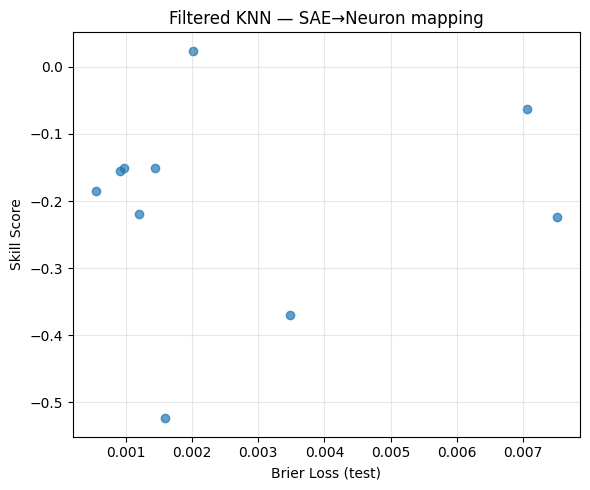

In [9]:
#!/usr/bin/env python3
# =====================================================================
# Allen Mouse Neurons — CLIP-SAE-ViT-L-14 → Neuron Mapping (Filtered KNN)
# =====================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from safetensors import safe_open
from huggingface_hub import snapshot_download
from transformers import CLIPProcessor, CLIPModel
from transformers.models.clip.modeling_clip import CLIPVisionModel
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)
print(f"Using device: {DEVICE}")

N_IMAGES = 118
N_TRIALS = 50
DATA_PATH = "/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
IMG_DIR = Path("/home/maria/MITNeuralComputation/vit_embeddings/images")
SAE_REPO = "zer0int/CLIP-SAE-ViT-L-14"
LOCAL_SAE_DIR = "./clip_sae_vitl14_weights"

# ---------------------------------------------------------------
# HELPERS
# ---------------------------------------------------------------
def compute_brier(y_true, y_pred, img_ids):
    """Aggregate trialwise predictions per image and compute Brier loss."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    return float(np.mean((agg["p"] - agg["y"]) ** 2))

# ---------------------------------------------------------------
# LOAD NEURAL DATA
# ---------------------------------------------------------------
dat = np.load(DATA_PATH)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
assert n_samples == N_IMAGES * N_TRIALS
img_ids_full = np.repeat(np.arange(N_IMAGES), N_TRIALS)
print(f"dat shape (neurons × trials): {dat.shape}")

mean_prob = Y_binary.mean()
print(f"Mean prob of spiking: {mean_prob:.4f}")
y_means = Y_binary.mean(axis=1)
print(f"Typical range: {y_means.min():.4f} – {y_means.max():.4f}")

# ---------------------------------------------------------------
# DOWNLOAD SAE REPO (if needed)
# ---------------------------------------------------------------
snapshot_download(repo_id=SAE_REPO, local_dir=LOCAL_SAE_DIR)

# ---------------------------------------------------------------
# LOAD CLIP MODEL
# ---------------------------------------------------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
vision_model: CLIPVisionModel = clip_model.vision_model

# ---------------------------------------------------------------
# FIND SAE ENCODER MATRIX
# ---------------------------------------------------------------
print("\n🔍 Scanning safetensors for encoder-like matrices...")
candidates = []
for f in Path(LOCAL_SAE_DIR).glob("*.safetensors"):
    with safe_open(f, framework="pt", device="cpu") as sf:
        for k in sf.keys():
            t = sf.get_tensor(k)
            if t.ndim == 2:
                candidates.append((f, k, t.shape))
                if t.shape[0]*t.shape[1] > 1_000_000:
                    print(f"  {f.name}: {k} {tuple(t.shape)}")

if not candidates:
    raise FileNotFoundError("No 2D tensors found.")
sae_path, enc_key, enc_shape = max(candidates, key=lambda x: x[2][0]*x[2][1])
print(f"→ Selected {sae_path.name}, key={enc_key}, shape={enc_shape}")

with safe_open(sae_path, framework="pt", device=DEVICE) as f:
    W = f.get_tensor(enc_key)
    bias = None
    for k in f.keys():
        if "bias" in k.lower():
            b = f.get_tensor(k)
            if b.ndim == 1:
                bias = b
                break

# orientation check
A, B = W.shape
if A > B:
    in_dim, out_dim = B, A
    W_use = W
else:
    in_dim, out_dim = A, B
    W_use = W.T

# bias fix
if bias is None or bias.shape[0] != out_dim:
    print(f"⚠️ Bias mismatch — creating zero bias of length {out_dim}")
    bias_use = torch.zeros(out_dim, device=DEVICE)
else:
    bias_use = bias

# ---------------------------------------------------------------
# SAE MODULE
# ---------------------------------------------------------------
class SAEEncoder(torch.nn.Module):
    def __init__(self, in_dim, out_dim, W_init, b_init):
        super().__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)
        with torch.no_grad():
            self.linear.weight.copy_(W_init)
            self.linear.bias.copy_(b_init)
    def forward(self, x):
        return torch.relu(self.linear(x))

sae = SAEEncoder(in_dim, out_dim, W_use.to(DEVICE), bias_use.to(DEVICE)).to(DEVICE)
sae.eval()
print(f"✓ SAE Linear(in_dim={in_dim}, out_dim={out_dim}) ready")

# ---------------------------------------------------------------
# EXTRACT SAE FEATURES
# ---------------------------------------------------------------
img_paths = sorted(IMG_DIR.glob("scene_*.png"))
assert len(img_paths) == N_IMAGES
print(f"\nExtracting SAE features for {N_IMAGES} images...")

feat_fn = lambda inputs: clip_model.get_image_features(**inputs)
sae_feats = []
for p in tqdm(img_paths, desc="Feature extraction"):
    img = Image.open(p).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        x = feat_fn(inputs)
        z = sae(x)
    sae_feats.append(z.squeeze().cpu().numpy())

Z_sae = np.stack(sae_feats)
print("SAE latent shape:", Z_sae.shape)

# ---------------------------------------------------------------
# PREPARE DATA
# ---------------------------------------------------------------
Z_sae_full = np.repeat(Z_sae, N_TRIALS, axis=0)
Z_sae_full = StandardScaler().fit_transform(Z_sae_full)

# ---------------------------------------------------------------
# 5-FOLD CV — FILTERED KNN
# ---------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(N_IMAGES)))

num_neurons_to_sample = min(10, n_neurons)
sampled_neurons = rng.choice(np.arange(n_neurons), size=num_neurons_to_sample, replace=False)
K_NEIGHBORS = 3
print(f"\nRunning filtered KNN (K={K_NEIGHBORS}) on {num_neurons_to_sample} neurons...")

records = []
for nid in tqdm(sampled_neurons, desc="Neurons"):
    y_all = Y_binary[nid]
    brier_folds, skill_folds = [], []

    for train_imgs, test_imgs in folds:
        train_mask = np.isin(img_ids_full, train_imgs)
        test_mask  = np.isin(img_ids_full, test_imgs)

        Z_train, Z_test = Z_sae_full[train_mask], Z_sae_full[test_mask]
        y_train, y_test = y_all[train_mask], y_all[test_mask]

        # per-image means
        y_train_mean = np.array([y_train[img_ids_full[train_mask]==i].mean() for i in train_imgs])
        y_test_mean  = np.array([y_test[img_ids_full[test_mask]==i].mean() for i in test_imgs])
        Z_train_mean = np.array([Z_train[img_ids_full[train_mask]==i].mean(axis=0) for i in train_imgs])
        Z_test_mean  = np.array([Z_test[img_ids_full[test_mask]==i].mean(axis=0) for i in test_imgs])

        # ---- FILTER LATENTS ----
        support = (Z_train_mean > 0).sum(axis=0)
        active1 = support >= 5
        stds = Z_train_mean.std(axis=0)
        active2 = stds > 1e-6
        active_mask = active1 & active2
        if active_mask.sum() == 0:
            continue

        # IDF weighting
        idf = 1.0 / np.log1p(support.clip(min=1))
        Z_train_mean *= idf
        Z_test_mean  *= idf

        # center latents
        Z_train_sel = Z_train_mean[:, active_mask]
        Z_test_sel  = Z_test_mean[:, active_mask]

        # subtract per-latent mean (axis=1 → each latent separately)
        Z_train_T = Z_train_sel.T - Z_train_sel.T.mean(axis=1, keepdims=True)
        Z_test_T  = Z_test_sel.T  - Z_test_sel.T.mean(axis=1, keepdims=True)

        # safety check
        if np.any(np.isnan(Z_train_T)):
            Z_train_T = np.nan_to_num(Z_train_T)
        if np.any(np.isnan(Z_test_T)):
            Z_test_T = np.nan_to_num(Z_test_T)

        # --- KNN search ---
        nbrs = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric="cosine")
        nbrs.fit(Z_train_T)
        dist, idx = nbrs.kneighbors(y_train_mean.reshape(1, -1))
        best_idxs, weights = idx[0], 1 - dist[0]
        weights /= weights.sum()

        z_train_pred = np.average(Z_train_T[best_idxs, :], axis=0, weights=weights)
        z_test_pred  = np.average(Z_test_T[best_idxs, :], axis=0, weights=weights)

        # ---- Linear calibration ----
        var_z = np.var(z_train_pred)
        if var_z < 1e-8:
            a, b = 0.0, y_train_mean.mean()
        else:
            a = np.cov(y_train_mean, z_train_pred)[0,1] / var_z
            b = y_train_mean.mean() - a * z_train_pred.mean()
        y_pred_test = np.clip(a * z_test_pred + b, 0, 1)

        # ---- Evaluate ----
        brier = float(np.mean((y_pred_test - y_test_mean)**2))
        brier_base = float(np.mean((y_train_mean.mean() - y_test_mean)**2))
        skill = 1.0 - (brier / max(brier_base, 1e-12))

        brier_folds.append(brier)
        skill_folds.append(skill)

    if len(brier_folds) == 0:
        continue

    records.append({
        "neuron_idx": int(nid),
        "Brier_SAE_mean": float(np.nanmean(brier_folds)),
        "Brier_SAE_std":  float(np.nanstd(brier_folds)),
        "Skill_mean":     float(np.nanmean(skill_folds)),
        "Skill_std":      float(np.nanstd(skill_folds)),
        "K": K_NEIGHBORS,
        "sae_file": sae_path.name,
        "enc_key": enc_key,
        "out_dim": int(out_dim)
    })

df_cv = pd.DataFrame(records)
out_csv = "clip_sae_vitl14_knn_filtered_results.csv"
df_cv.to_csv(out_csv, index=False)
print(f"\n✅ Saved → {out_csv}")

# ---------------------------------------------------------------
# PLOT
# ---------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df_cv["Brier_SAE_mean"], df_cv["Skill_mean"], alpha=0.7)
plt.xlabel("Brier Loss (test)")
plt.ylabel("Skill Score")
plt.title("Filtered KNN — SAE→Neuron mapping")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("clip_sae_vitl14_knn_filtered_plot.png", dpi=200)
plt.show()


In [10]:
df_cv

,neuron_idx,Brier_SAE_mean,Brier_SAE_std,Skill_mean,Skill_std,K,sae_file,enc_key,out_dim
0,3369,0.003473,0.002412,-0.369999,0.383993,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
1,30339,0.001441,0.000655,-0.150537,0.167162,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
2,3498,0.000917,0.000343,-0.154658,0.076424,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
3,25660,0.000973,0.000286,-0.150348,0.183627,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
4,17205,0.000550,0.000096,-0.184795,0.245850,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
5,16975,0.001197,0.000365,-0.219823,0.144573,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
6,27341,0.007513,0.007234,-0.223031,0.207922,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
7,3692,0.001594,0.001117,-0.523801,0.575631,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
8,7899,0.007062,0.005509,-0.063105,0.077034,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
9,33661,0.002014,0.000764,0.024112,0.169497,3,model.safetensors,text_model.embeddings.token_embedding.weight,49408
